In [1]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import numpy as np

with open('vr_demo.csv', encoding='utf-8') as f:
    df = pd.read_csv(f, skipinitialspace=True, encoding='utf-8')
features = df.columns.values[:-1]
targets = df.columns.values[-1]
seed = 42
X, y = df[features], df[targets]
X_trn, X_test, y_trn, y_test = train_test_split(X, y, train_size=0.7, random_state=seed)

regressor = GradientBoostingRegressor(random_state=seed)
    
pipeline = Pipeline(steps=[
        ('Scale', StandardScaler()),
        ('Impute', SimpleImputer(strategy='mean')),#KNNImputer()),
        ('Regression', regressor)])
pipeline.fit(X_trn.values, y_trn.values)
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2:.3f}, RMSE: {rmse:.2f}")

R²: 0.665, RMSE: 0.17


C:\Users\ChrisProsser\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


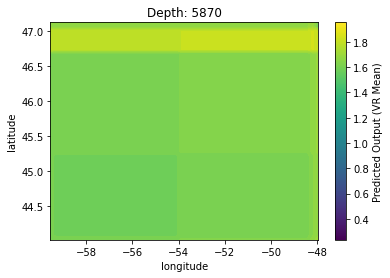

In [4]:
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\ChrisProsser\AppData\Roaming\ffmpeg\bin\ffmpeg.exe"
LEVELS = 8  # can make high e.g. 100 to get very smooth color gradient
CMAP = 'viridis'

# Create a figure and axis
fig, ax = plt.subplots()

# Set the depth range
depth, lat, lon = features[0], features[1], features[2]
depth_range = np.linspace(df[depth].min(), df[depth].max(), 100)
lat_range = np.linspace(df[lat].min(), df[lat].max(), 50)
lon_range = np.linspace(df[lon].min(), df[lon].max(), 50)
lat_grid, lon_grid = np.meshgrid(lat_range, lon_range)

# Compute all predictions
all_inputs = np.column_stack((np.repeat(depth_range, lat_grid.size), 
                              np.tile(lat_grid.flatten(), len(depth_range)), 
                              np.tile(lon_grid.flatten(), len(depth_range))))
all_predictions = pipeline.predict(all_inputs)
all_predictions = all_predictions.reshape(len(depth_range), lat_grid.shape[0], lat_grid.shape[1])

# Get the global minimum and maximum of all predictions to set the colorbar norm
vmin, vmax = all_predictions.min(), all_predictions.max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# Create the colorbar
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=CMAP), ax=ax)
cbar.set_label('Predicted Output (VR Mean)')

# Intialise with zero depth
cs = ax.contourf(lon_grid, lat_grid, np.full(lat_grid.shape, df[depth].min()),
                 cmap=CMAP, levels=LEVELS, norm=norm)

# Define the function for updating the plot for each frame
def update(depth_index):
    depth = depth_range[depth_index]
    y_range = all_predictions[depth_index]

    # Clear the axis contents
    ax.cla()
    
    # Create a contour plot of the model predictions
    cs = ax.contourf(lon_grid, lat_grid, y_range, cmap=CMAP, 
                     levels=LEVELS, norm=norm)
    ax.set_title(f'Depth: {depth:.0f}')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    
ax.set_xlim(df[lat].min(), df[lat].max())
ax.set_ylim(df[lon].min(), df[lon].max())

# Create the animation using the update function and the depth range
ani = FuncAnimation(fig, update, interval=50, frames=range(len(depth_range)))
ani.save('contour_lat_lon_depth_gbr_ani.mp4', writer='ffmpeg', fps=20)

# Show the animation
HTML(ani.to_jshtml())
